# Model monitoring dashboard example

This notebook currently requires the plotly library to be installed.

In [5]:
import weave
weave.use_frontend_devmode()
from weave import syndata_mon

## Create synthetic data

In [45]:
#preds = syndata_mon.random_predictions(10)

#predictions = weave.save(preds, 'predictions')
#len(preds.column('prompt').to_pylist_raw())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 266.87it/s]


In [4]:
import logging
import json
import os
from pathlib import Path

import tiktoken
import faiss
import numpy as np
from tenacity import (
    before_sleep_log,
    retry,
    retry_if_exception_type,
    stop_after_attempt,
    wait_exponential,
)
import openai

logger = logging.getLogger(__name__)
openai.api_key = os.environ['OPENAI_API_KEY']

# OpenAI API functions
retry_openai_decorator = retry(
        reraise=True,
        stop=stop_after_attempt(4),
        wait=wait_exponential(multiplier=1, min=4, max=10),
        retry=(
            retry_if_exception_type(openai.error.Timeout)
            | retry_if_exception_type(openai.error.APIError)
            | retry_if_exception_type(openai.error.APIConnectionError)
            | retry_if_exception_type(openai.error.RateLimitError)
            | retry_if_exception_type(openai.error.ServiceUnavailableError)
        ),
        before_sleep=before_sleep_log(logger, logging.WARNING),
    )

@retry_openai_decorator
def openai_embed(model, input):
    return openai.Embedding.create(input = input, model=model)

@retry_openai_decorator
def openai_chatcompletion(model, messages):
    return openai.ChatCompletion.create(
        model="gpt-3.5-turbo", # The deployment name you chose when you deployed the ChatGPT or GPT-4 model.
        messages = messages
    )

# Helper to efficiently embed a set of documents using the OpenAI embedding API
# This is from langchain

embedding_ctx_length = 8191
OPENAI_EMBEDDING_MODEL = "text-embedding-ada-002"
chunk_size = 1000

from typing import List

def embed_texts(texts: List[str], embedding_model: str) -> List[List[float]]:
    embeddings: List[List[float]] = [[] for _ in range(len(texts))]
    tokens = []
    indices = []
    encoding = tiktoken.model.encoding_for_model(embedding_model)
    for i, text in enumerate(texts):
        if embedding_model.endswith("001"):
            # See: https://github.com/openai/openai-python/issues/418#issuecomment-1525939500
            # replace newlines, which can negatively affect performance.
            text = text.replace("\n", " ")
        token = encoding.encode(
            text,
            disallowed_special="all",
        )
        for j in range(0, len(token), embedding_ctx_length):
            tokens += [token[j : j + embedding_ctx_length]]
            indices += [i]

    batched_embeddings = []
    _chunk_size = chunk_size
    for i in range(0, len(tokens), _chunk_size):
        response = openai_embed(
            embedding_model,
            input=tokens[i : i + _chunk_size],
        )
        batched_embeddings += [r["embedding"] for r in response["data"]]

    results: List[List[List[float]]] = [[] for _ in range(len(texts))]
    num_tokens_in_batch: List[List[int]] = [[] for _ in range(len(texts))]
    for i in range(len(indices)):
        results[indices[i]].append(batched_embeddings[i])
        num_tokens_in_batch[indices[i]].append(len(tokens[i]))

    for i in range(len(texts)):
        _result = results[i]
        if len(_result) == 0:
            average = embed_with_retry(
                embedding_model,
                input="",
            )["data"][0]["embedding"]
        else:
            average = np.average(
                _result, axis=0, weights=num_tokens_in_batch[i]
            )
        embeddings[i] = (average / np.linalg.norm(average)).tolist()

    return embeddings

In [74]:
import pandas
data = pandas.read_csv('/Users/shawn/datasets/wandb_export_2023-06-03T15_01_20.066-07_00.csv')

In [92]:
data

,request_timestamp,request_id,user,question,question_id,wandbot_answer,retrived_source_documents,answer_elapsed_time_s,synth_grader_feedback,grader_justification,...,eval_total_tokens,eval_tokens_for_source_docs,eval_prompt_tokens,eval_completion_tokens,is_source_documents_truncated,wandb_run_id,wandbot_model,wandbot_temperature,hyde_llm_temperature,eval_model
0,1679616219000,s17gs93ou5jlaxjm,ChaosOverlord262,Can one run use another run's output Artifact ...,3280,"Yes, you can use another run's output Artifact...","{""source_doc_0"": {""page_content"": ""description...",35.044511,POSITIVE,The WANDBOT_RESPONSE accurately answers the US...,...,3956,3016,3902,54,True,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
1,1679616281000,699plqtuu28raj4g,ThunderDestroyer1117,How can you specify the project you want to up...,8227,To specify the project you want to upload to u...,"{""source_doc_0"": {""page_content"": ""Here's a sa...",30.080976,POSITIVE,The WANDBOT_RESPONSE accurately answers the US...,...,3961,3075,3902,59,True,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
2,1679616844000,86ygtbcoa14234vk,AstralDragon879,What is the maximum number of authentication k...,8322,The documentation for the `wandb login` comman...,"{""source_doc_0"": {""page_content"": ""User Login\...",28.475478,POSITIVE,The WANDBOT_RESPONSE is accurate. The document...,...,3313,2483,3260,53,False,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
3,1679617286000,1xslj0xaxc3ylldv,InfernoDragon140,Is Wandb Pull only used for downloading files ...,2683,"Yes, `wandb pull` is primarily used for downlo...","{""source_doc_0"": {""page_content"": ""For informa...",42.099218,POSITIVE,The WANDBOT_RESPONSE is accurate. It correctly...,...,3924,2989,3843,81,False,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
4,1679618128000,tuhnbmh2waj3rzfx,ArcaneAssassin956,What kind of behavior can be altered in the Ed...,6993,"In the Edit panel of a W&B visualization, the ...","{""source_doc_0"": {""page_content"": ""Customize t...",51.059539,POSITIVE,The WANDBOT_RESPONSE accurately states that in...,...,3526,2673,3446,80,False,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9458,1685319531000,a8rcgzi7gbov0pk7,ShadowConqueror182,What is the difference between the `add_node` ...,4499,The `add_node` method in the `Graph` class in ...,"{""source_doc_0"": {""page_content"": ""Graph\n\nVi...",41.198267,POSITIVE,The WANDBOT_RESPONSE accurately explains the d...,...,3967,3042,3902,65,True,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
9459,1685320336000,a8rcgzi7gbov0pk7,ThunderDragon1064,What is the difference between the `add_node` ...,4499,The `add_node` method in the `Graph` class in ...,"{""source_doc_0"": {""page_content"": ""Graph\n\nVi...",41.198267,POSITIVE,The WANDBOT_RESPONSE accurately explains the d...,...,3967,3042,3902,65,True,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
9460,1685320436000,hspgb2teomu3itct,PhantomGladiator68,What is the `history` object?,8596,The `history` object is used to track metrics ...,"{""source_doc_0"": {""page_content"": ""Question:\n...",21.819577,POSITIVE,The WANDBOT_RESPONSE is accurate. The SUPPORTI...,...,3849,3030,3793,56,False,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo
9461,1685320774000,pkrn3kb6wup4ed0y,EclipseConqueror922,Can you delete assets using `wandb`?,8823,"Yes, you can delete artifacts interactively wi...","{""source_doc_0"": {""page_content"": ""description...",21.870588,POSITIVE,The WANDBOT_RESPONSE accurately answers the US...,...,4004,3084,3902,102,True,g4rjeq92,gpt-3.5-turbo,0,0.3,gpt-3.5-turbo


In [81]:
embeddings = embed_texts(data['question'][:100], OPENAI_EMBEDDING_MODEL)

In [115]:
from weave.ecosystem import umap

In [116]:
umap.umap_projection(embeddings, {})

AttributeError: module 'weave.ecosystem.umap' has no attribute 'umap_projection'

In [60]:
len(embeddings)

7579

In [49]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [82]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(embeddings)

/var/folders/yx/6rz83q2945bfbq6l0gjmdpc80000gp/T/ipykernel_77523/2044255912.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');


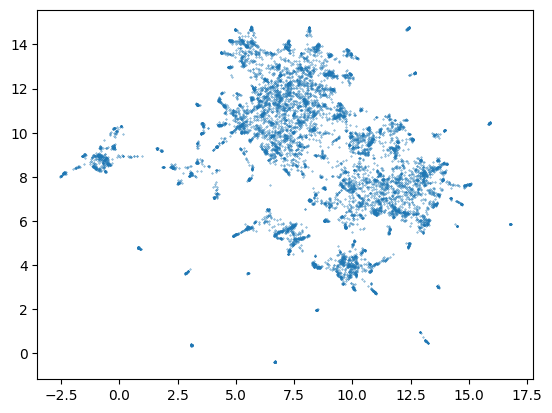

In [83]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');

In [84]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(embeddings)

In [106]:
clusterable_embedding.shape

(9463, 2)

/var/folders/yx/6rz83q2945bfbq6l0gjmdpc80000gp/T/ipykernel_77523/2335800109.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral');


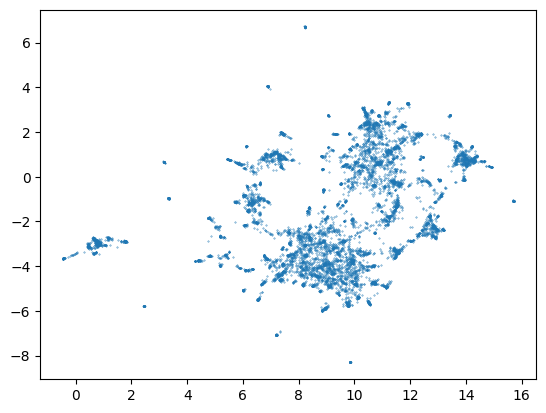

In [85]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral');

In [86]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=50,
).fit_predict(clusterable_embedding)

In [87]:
#labels
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52]),
 array([2784,   55,   54,   85,  103,   84,   60,  202,   71,  162,  100,
          60,  329,  138,  172,   55,   60,   62,  412,   51,   65,  383,
          59,  282,  164,   56,  271,   83,   56,  107,  161,   62,  227,
          86,  119,  283,   88,   51,   61,  104,  132,  143,  106,   83,
          80,   96,  146,  127,   84,  101,  105,  140,   68,  185]))

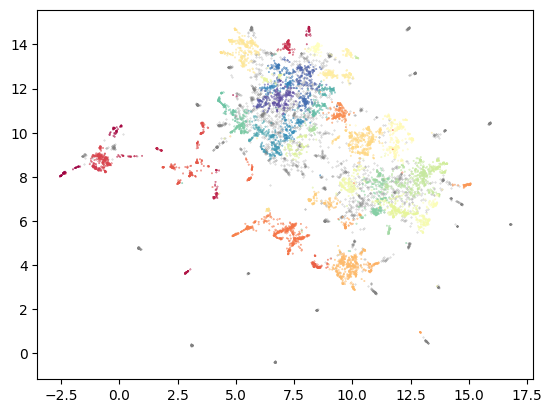

In [88]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [104]:
data['embedding_x'] = standard_embedding[:,0]
data['embedding_y'] = standard_embedding[:,1]
data['cluster_id'] = labels.astype(str)

In [105]:
weave.show(data)

## Create a Weave Board for the data

In [ ]:
from weave.panels_py import panel_autoboard

panel_autoboard.auto_panels(predictions)